# Image Segmentation

Learn about the three types of image segmentation (semantic, instance, and panoptic), their applications, and the appropriate machine learning model architectures to perform each of them.

In [51]:
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn

import matplotlib.pyplot as plt

## Introduction to image segmentation

### Creating binary masks

Images for segmentation tasks are typically annotated with pixel-level masks. Consider this image of an Egyptian Mau cat.

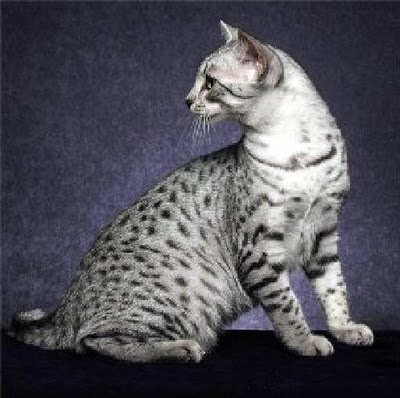

In this and the next exercise, you will use the corresponding mask to segment the cat out of the image. First, you will need to load the mask and binarize it.

Instructions:

- Load the mask image stored in `annotations/Egyptian_Mau_123.png` and assign it to `mask`.
- Create a `binary_mask` from `mask_tensor` where each pixel equal to `1/255` is assigned a tensor value of `1.0`, and the remaining pixels are assigned a tensor value of `0.0`.

In [11]:
# Load mask image
mask = Image.open("Egyptian_Mau_123.jpg")

# Transform mask to tensor
transform = transforms.Compose([transforms.ToTensor()])
mask_tensor = transform(mask)

# Create binary mask
binary_mask = torch.where(
    mask_tensor == 1 / 255,
    torch.tensor(1.0),
    torch.tensor(0.0),
)

# Print unique mask values
print(binary_mask.unique())

tensor([0., 1.])


### Segmenting image with a mask

With the binary mask ready, you can use it to segment the object, that is the cat, out of the image.

To do so, you will need to load the original image and transform it to a tensor. Next, you will create the object tensor by masking the original image. Finally, you will display the result.

Instructions:

- Create `image_tensor` by applying the `toTensor()` `transform` to the raw image.
- Segment the image by masking the `image_tensor` with the `binary_mask`, assigning the result to `object_tensor`.
- Apply the already defined `to_pil_image` transform to the `object_tensor` in order to display it.

In [ ]:
# Load image and transform to tensor
image = Image.open("images/Egyptian_Mau_123.jpg")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image)

# Segment object out of the image
object_tensor = image_tensor * binary_mask

# Convert segmented object to image and display
to_pil_image = transforms.ToPILImage()
object_image = to_pil_image(object_tensor)
plt.imshow(object_image)
plt.show()

## Instance segmentation with Mask R-CNN

### Segmenting with pre-trained Mask R-CNN

In this exercise, you will use the pre-trained Mask R-CNN model to perform instance segmentation on the following image of two cats.
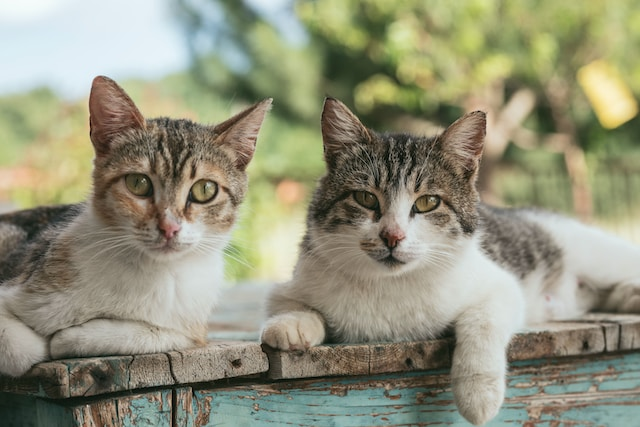

The model you will use has been pre-trained on the COCO dataset, which contains images of common objects, including animals. Thanks to this, the model should be able to recognize cats out of the box, without the need to fine-tune it.

Your task is to load the model and the two cats image, prepare the image, and pass it to the model to obtain the predictions.

Instructions:

- Import `maskrcnn_resnet50_fpn` from the appropriate `torchvision` module.
- Load the `pretrained` Mask R-CNN to `model`.
- Transform the two cats image to a tensor and unsqueeze it.
- Perform inference by passing the image to the model and assign the output to `prediction`.

In [24]:
# Import maskrcnn_resnet50_fpn
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights


# Load a pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()

# Load an image and convert to a tensor
image = Image.open("two_cats.jpg")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

# Perform inference
with torch.no_grad():
    prediction = model(image_tensor)
    print(prediction)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\jcamp/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100.0%


[{'boxes': tensor([[  0.0000,  68.4634, 265.5480, 373.9487],
        [260.9958,  95.7566, 639.8625, 407.8638],
        [  0.0000, 237.8367, 633.6594, 427.0000],
        [168.4670,   0.0000, 628.7657, 219.3080],
        [ 11.7721, 327.7047, 557.0749, 422.9796]]), 'labels': tensor([17, 17, 15, 64, 15]), 'scores': tensor([0.9979, 0.9957, 0.2405, 0.1367, 0.1005]), 'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,


### Analyzing model output

Having obtained the prediction from a pre-trained model, you can now analyze it in detail.

You will find it is a list of length one (you made prediction for just one image) with a dictionary with four keys. `labels` are integers indicating predicted classes, and `scores` are corresponding class probabilities. You can access the list of the class names corresponding to `labels` as `class_names`.

What are the predicted categories and their associated scores for the top two masks?

In [30]:
class_names = MaskRCNN_ResNet50_FPN_Weights.DEFAULT.meta["categories"]
print(class_names[17])

cat


In [25]:
print(prediction[0]["labels"])

tensor([17, 17, 15, 64, 15])


In [31]:
print(prediction[0]["scores"])

tensor([0.9979, 0.9957, 0.2405, 0.1367, 0.1005])


### Displaying soft masks

In the previous exercise, you have learned that the top two most likely objects the Mask R-CNN model has segmented are both cats. Now, you will display the masks for these two cats overlaid on top of the original image to visually verify their accuracy. This will require iterating over the two masks, and for each of them, plotting the original image followed by a semi-transparent mask on top of it.

Instructions:

- Extract masks and labels from the `prediction`, assigning them to `masks` and `labels`, respectively.
- Inside the for-loop, display the `i`-th mask over the image by passing `mask[i, 0]` to the plotting function, using the `"jet"` color map and setting the transparency parameter to `0.5`.

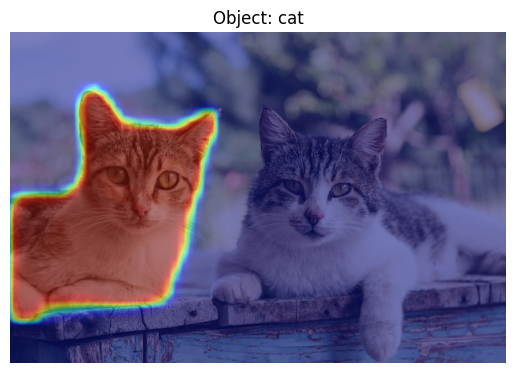

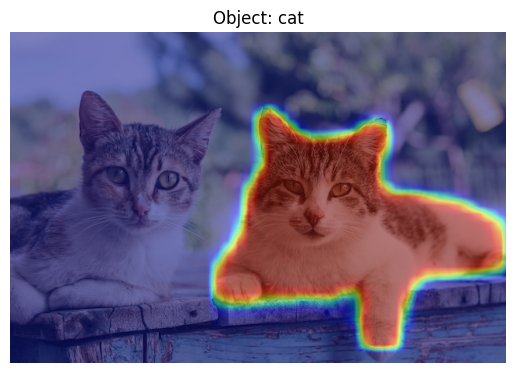

In [49]:
# Extract masks and labels from prediction
masks = prediction[0]["masks"]
labels = prediction[0]["labels"]

# Plot image with two overlaid masks
for i in range(2):
    plt.imshow(image)
    # Overlay the i-th mask on top of the image
    plt.imshow(masks[i, 0], cmap="jet", alpha=0.5)
    plt.title(f"Object: {class_names[labels[i]]}")
    plt.axis("off")
    plt.show()

## Semantic segmentation with U-net

### Building a U-Net: layers definitions

In this and the next exercise, you will construct a U-Net architecture from scratch. Here, you start with defining the `__init__()` method where you will define layers and blocks of layers for the model to use.

The encoder and transposed convolution have already been defined for you. What's left is the decoder's convolutional blocks. You need to pass the appropriate number of input and output channels to each of them, taking into account the skip connections.

The first block, `dec1`, will take as input the concatenation of `upconv3` output with the `enc3` output. The `dec1` output, in turn, should be equal to `enc3` output. Can you fill-in all the missing input and output sizes?

In [60]:
def conv_block(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels),
        nn.ReLU(inplace=True),
    )

Instructions:

- Define the three convolutional blocks in the decoder by passing the appropriate number of input and output channels to each of them.

In [53]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        # Define the decoder blocks
        self.dec1 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec3 = self.conv_block(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

### Building a U-Net: forward method

With the encoder and decoder layers defied, you can now implement the `forward()` method of the U-net. The inputs have already been passed through the encoder for you. However, you need to define the last decoder block.

The goal of the decoder is to upsample the feature maps so that its output is of the same height and width as the U-Net's input image. This will allow you to obtain pixel-level semantic masks.

Instructions:

- Define the last decoder block, using `torch.cat()` to form the skip connection.

In [54]:
def forward(self, x):
    x1 = self.enc1(x)
    x2 = self.enc2(self.pool(x1))
    x3 = self.enc3(self.pool(x2))
    x4 = self.enc4(self.pool(x3))

    x = self.upconv3(x4)
    x = torch.cat([x, x3], dim=1)
    x = self.dec1(x)

    x = self.upconv2(x)
    x = torch.cat([x, x2], dim=1)
    x = self.dec2(x)

    # Define the last decoder block with skip connections
    x = self.upconv1(x)
    x = torch.cat([x, x1], dim=1)
    x = self.dec3(x)

    return self.out(x)

### Running semantic segmentation

Good job designing the U-Net! You will find an already pre-trained model very similar to the one you have just built available to you. This model has been trained on a large set of images and contains a few small additions to the architecture, such as the batch norm layers.

You can instantiate the model as `UNet()`, which will provide the model with the pre-trained weights. You task is to use it to produce segmentation masks for the following image of a car.

In [61]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        # Define the decoder blocks
        self.dec1 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec3 = self.conv_block(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))

        x = self.upconv3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.dec1(x)

        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        # Define the last decoder block with skip connections
        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec3(x)

        return self.out(x)

Instructions:

- Instantiate `UNet()` in a variable called `model`.
- Load the image at `car.jpg` to a variable called `image`.
- Produce segmentation masks by passing the image to the model and `squeeze(0)`-ing the output.

In [66]:
# Load model
model = UNet(3,1)
model.eval()

# Load and transform image
image = Image.open("car.jpg")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

# Predict segmentation mask
with torch.no_grad():
    prediction = model(image_tensor).squeeze(0)

# Display mask
plt.imshow(prediction[1, :, :])
plt.show()

TypeError: Conv2d.__init__() missing 1 required positional argument: 'kernel_size'

## Panoptic segmentation

### Setup up semantic masks

A common way to perform panoptic segmentation is to combine together the outputs of semantic and instance segmentation. Consider the following image of a New York street.

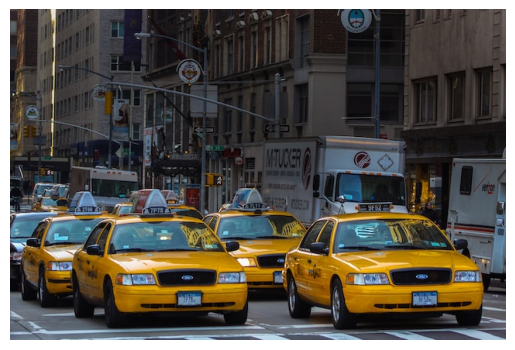

Your task is to segment it panoptically, such that each cab is identified as a separate object, while distinguishing between the asphalt and building backgrounds.

To achieve it, you will start by producing a semantic mask with a pre-trained U-Net, available to you as `UNet()`. Hopefully, it should distinguish between the two background types (but not between particular cabs)!

Instructions:

- Instantiate the U-Net model as `model`.
- Generate `semantic_masks` by passing the input image tensor to the model.
- Create single semantic mask by choosing the highest-probability class for each pixel.

In [ ]:
# Instantiate the model
model = UNet()

# Produce semantic masks for the input image
with torch.no_grad():
    semantic_masks = model(image_tensor) 

# Choose highest-probability class for each pixel
semantic_mask = torch.argmax(semantic_masks, dim=1)

# Display the mask
plt.imshow(semantic_mask.squeeze(0))
plt.axis("off")
plt.show()

### Overlay instance masks

Good job producing the semantic mask in the previous exercise! Now, you can overwrite it with instance masks in the locations where the objects have been identified by the instance segmentation model.

You will use the pre-trained `MaskRCNN` available in your workspace to produce instance segmentation masks. Then, you will loop over these masks and for each of them, you will overlay the parts where an object is detected with high certainty on top of the semantic mask.

Instructions:

- Initialize `panoptic_mask` by cloning the `semantic_mask`.
- Define the for-loop to iterate over the instance masks, calling the iterator variable `mask`.
- For each instance mask, in location where it is larger than `0.5`, overwrite the panoptic mask with the current `istance_id`.

In [ ]:
# Instantiate model and produce instance masks
model = MaskRCNN()
with torch.no_grad():
    instance_masks = model(image_tensor)[0]["masks"]

# Initialize panoptic mask as semantic_mask
panoptic_mask = torch.clone(semantic_mask)

# Iterate over instance masks
instance_id = 3
for mask in instance_masks:
    # Set panoptic mask to instance_id where mask > 0.5
    panoptic_mask[mask > 0.5] = instance_id
    instance_id += 1
    
# Display panoptic mask
plt.imshow(panoptic_mask.squeeze(0))
plt.axis("off")
plt.show()